# LA County Board of Supervisors - 2nd District Data Analysis

These maps visualize campaign donations made this campaign cycle to the three candidates running to replace Mark Ridley-Thomas on the Board of Supervisors, L.A. County's governing body. 

In [1]:
import pandas as pd
import psycopg2 as pg
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rc
%matplotlib inline
import sqlalchemy
import pandas.io.sql as psql
import numpy as np
import geopandas as gpd
import descartes
import geojson
import json
import jenkspy
import altair as alt
import altair_latimes as lat
alt.renderers.enable('notebook')
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')

ThemeRegistry.enable('latimes')

### Get the data from our larger donations database of committees in all countywide races back to 2007. 

In [2]:
database_con = pg.connect("dbname=campaigns user=postgres")

In [3]:
alldonations =  psql.read_sql("SELECT * FROM contributions", database_con)

### Let's clean up the spaces and capitalization in field names

In [4]:
alldonations.columns = alldonations.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [5]:
alldonations.head(2)

last_name first_name committee_id                      committee_name  \
0    Barger    Kathryn      1414462  Kathryn Barger for Supervisor 2020   
1    Barger    Kathryn      1414462  Kathryn Barger for Supervisor 2020   

  office_type district_number schedule   type        date  amount_rcvd  ...  \
0         CSU             C05        A  Other  2018-12-31       1500.0  ...   
1         CSU             C05        A  Other  2018-12-31       1500.0  ...   

   employer int_name int_city int_state int_zip_code int_occupation  \
0                                                                     
1                                                                     

  int_employer doc_id rec_id       x  
0                       2557  164858  
1                       2557  164916  

[2 rows x 31 columns]

### Some date parsing

In [6]:
alldonations['date'] = pd.to_datetime(alldonations['date'], errors='coerce')

In [7]:
alldonations['year'], alldonations['month'] = alldonations['date'].dt.year, alldonations['date'].dt.month
alldonations['year'] = alldonations['year'].astype(str)
alldonations['month'] = alldonations['month'].astype(str)
alldonations['amount_rcvd'] = alldonations['amount_rcvd'].astype(int)
alldonations['monthyear'] = pd.to_datetime(alldonations['date']).map(lambda dt: dt.replace(day=1))
alldonations['candidate'] = alldonations['first_name'] + ' ' + alldonations['last_name']
alldonations['candidate'] = alldonations['candidate'].str.title()
alldonations['candidate'] = alldonations['candidate'].str.replace("Holly J. Mitchell", "Holly Mitchell")
alldonations['type'] = alldonations['type'].str.replace("Small Contributor Committee", "Small Donor Committee")
alldonations['last_name'] = alldonations['last_name'].str.upper()
alldonations['committee_name'] = alldonations['committee_name'].str.upper()
alldonations['first_name'] = alldonations['first_name'].str.upper()
alldonations['months'] = alldonations['date'].dt.strftime('%m/%Y').astype(str)

In [8]:
agg_all_types = alldonations.groupby(['year', 'type']).agg(['sum', 'size', 'mean']).round(0).reset_index()
flat_columns = [''.join(t) for t in agg_all_types.columns]
agg_all_types.columns = flat_columns

### Filter out older contributions.

In [9]:
nudonations = alldonations[alldonations.date > '2018-06-30']

### Aggregate by month/year to make sure we filter appropriately. 

In [10]:
nudonations[['date', 'amount_rcvd']].groupby(nudonations.date.dt.to_period("M")).agg(['sum', 'size', 'mean'])

amount_rcvd                   
                sum  size         mean
date                                  
2018-07       87659   150   584.393333
2018-08      232188   323   718.848297
2018-09      304368   473   643.484144
2018-10      609077   803   758.501868
2018-11      176696   207   853.603865
2018-12      859396   700  1227.708571
2019-01      179180   187   958.181818
2019-02      607890   697   872.152080
2019-03      479805   509   942.642436
2019-04      419783   563   745.618117
2019-05      545495   706   772.655807
2019-06     1003559  1398   717.853362

## Three stories: Group 2020 contributions data by 1) race, 2) time, 3) zip code.

### Select only donations to candidates running in District 2

In [11]:
thiscycle = nudonations[(nudonations['date'] > '2018-06-30')]
district_two_candidates = (['PERRY','WESSON','MITCHELL','JEONG'])
thiscycle = thiscycle[thiscycle['last_name'].isin(district_two_candidates)]

In [12]:
thiscycle.groupby('candidate').agg(['sum', 'size', 'mean'])

amount_rcvd                   amount_pd          
                       sum size         mean       sum size mean
candidate                                                       
Chan Jeong           46100   82   562.195122       0.0   82  0.0
Herb Wesson        1119445  960  1166.088542       0.0  960  0.0
Holly Mitchell      564594  767   736.106910       0.0  767  0.0
Jan Perry           509760  893   570.839866       0.0  893  0.0

In [13]:
thiscycle.head(3)

last_name first_name committee_id              committee_name office_type  \
4     WESSON       HERB      1414475  WESSON FOR SUPERVISOR 2020         CSU   
71    WESSON       HERB      1414475  WESSON FOR SUPERVISOR 2020         CSU   
72    WESSON       HERB      1414475  WESSON FOR SUPERVISOR 2020         CSU   

   district_number schedule       type       date  amount_rcvd  ...  \
4              C02        A      Other 2019-04-29         1500  ...   
71             N/A        A  Committee 2018-12-31         1500  ...   
72             N/A        A  Committee 2018-12-31         1500  ...   

    int_occupation int_employer doc_id rec_id       x  year month  monthyear  \
4                                        2581  167892  2019     4 2019-04-01   
71                                       2546  164456  2018    12 2018-12-01   
72                                       2546  164634  2018    12 2018-12-01   

      candidate   months  
4   Herb Wesson  04/2019  
71  Herb Wesson  12/2018  
72  Herb Wesson  12/2018  

[3 rows x 36 columns]

In [14]:
thiscycletrim = thiscycle[[
    'last_name',
    'first_name',
    'candidate',
    'committee_id',
    'committee_name',
    'office_type',
    'district_number',
    'schedule',
    'type',
    'date',
    'amount_rcvd',
    'description',
    'contributor_first_name',
    'contributor_last_name',
    'contributor_address',
    'contributor_city',
    'contributor_state',
    'contributor_zip_code',
    'occupation',
    'employer',
    'doc_id',
    'rec_id',
    'year',
    'month',
    'months'
]]

# EXPORT FOR 'THISCYCLE' TABLE

In [15]:
thiscycletrim.to_csv("/Users/mhustiles/Desktop/github/la-supervisors-donations-2020/data/thiscycle.csv", index=False)

***

In [16]:
alldonations.to_csv("/Users/mhustiles/Desktop/all_county_donations_2007-2019.csv", index=False)

### 1) Create a dataframe with summary stats for each campaign this cycle

In [17]:
thiscycletotals = thiscycle.groupby(['candidate'], as_index=False).agg({'amount_rcvd': ['size', 'mean', 'sum']}, as_index=False)
thiscycletotalszips = thiscycle.groupby(['candidate', 'contributor_zip_code'], as_index=False).agg({'amount_rcvd': ['sum']}, as_index=False).reset_index()

# EXPORT FOR 'THISCYCLETOTALS' TABLE

In [18]:
thiscycletotals.to_csv("/Users/mhustiles/Desktop/github/la-supervisors-donations-2020/data/thiscycletotals.csv", index=False)

### 1) Clean up the hierarchical column structure. Standardize names in all caps.

In [19]:
flat_columns = [''.join(t) for t in thiscycletotals.columns]
thiscycletotals.columns = flat_columns
thiscycletotals['amount_rcvdmean'] = thiscycletotals['amount_rcvdmean'].astype(int)
thiscycletotals['amount_rcvdmean'] = thiscycletotals['amount_rcvdmean'].round()

flat_columns = [''.join(t) for t in thiscycletotalszips.columns]
thiscycletotalszips.columns = flat_columns

In [20]:
wide_zips = pd.pivot_table(thiscycletotalszips, values='amount_rcvdsum', 
                     index=['contributor_zip_code'], 
                     columns='candidate', 
                              fill_value=0).reset_index()

In [21]:
wide_zips.columns = wide_zips.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
wide_zips.sort_values(['contributor_zip_code'],ascending=False).head(3)

candidate contributor_zip_code  chan_jeong  herb_wesson  holly_mitchell  \
572                      98664           0            0               0   
571                      98134           0            0               0   
570                      98104           0            0            1500   

candidate  jan_perry  
572              200  
571             1500  
570                0

### Who got the most money from each zip code? 

In [22]:
wide_zips.head(3)

candidate contributor_zip_code  chan_jeong  herb_wesson  holly_mitchell  \
0                        10004           0            0             250   
1                        10010           0            0            1000   
2                        10011           0            0            1500   

candidate  jan_perry  
0                  0  
1                  0  
2                  0

In [23]:
wide_zips['winner'] = wide_zips[['chan_jeong','herb_wesson','holly_mitchell','jan_perry']].idxmax(axis=1)
wide_zips.head(3)

candidate contributor_zip_code  chan_jeong  herb_wesson  holly_mitchell  \
0                        10004           0            0             250   
1                        10010           0            0            1000   
2                        10011           0            0            1500   

candidate  jan_perry          winner  
0                  0  holly_mitchell  
1                  0  holly_mitchell  
2                  0  holly_mitchell

In [24]:
a = wide_zips[['chan_jeong','herb_wesson','holly_mitchell','jan_perry']]
wide_zips['winner'] = a.idxmax(axis=1)
s = a.eq(a.max(axis=1), axis=0).sum(axis=1)
wide_zips['winner'] = wide_zips['winner'].mask(s > 1, 'Tie')
wide_zips['winner'] = wide_zips['winner'].str.replace("_", " ").str.title()

In [25]:
wide_zips.head(3)

candidate contributor_zip_code  chan_jeong  herb_wesson  holly_mitchell  \
0                        10004           0            0             250   
1                        10010           0            0            1000   
2                        10011           0            0            1500   

candidate  jan_perry          winner  
0                  0  Holly Mitchell  
1                  0  Holly Mitchell  
2                  0  Holly Mitchell

# EXPORT FOR 'WIDE_ZIPS_TOTALS' TABLE

In [26]:
wide_zips.to_csv("/Users/mhustiles/Desktop/github/la-supervisors-donations-2020/data/wide_zips_totals.csv", index=False)

***

In [27]:
#LA County zip codes
lazipsmap = gpd.read_file("/Users/mhustiles/Desktop/data/GIS/LA/la_county_gis_zipcodes/la_county_zipcodes_dissolved.geojson")

In [28]:
#LA County zip codes
la_zips_map = gpd.read_file("/Users/mhustiles/Desktop/data/GIS/LA/la_county_gis_zipcodes/la_county_zipcodes.geojson")

In [29]:
#CA ztcas simple
cazipsmap = gpd.read_file("/Users/mhustiles/Desktop/data/GIS/californiazips.geojson")

#CA ztcas detailed
ca_zctas_map = gpd.read_file("/Users/mhustiles/Desktop/data/GIS/cazips.geojson")

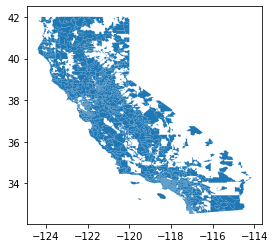

In [30]:
ca_zctas_map.plot()

In [31]:
la_zips_map.dtypes

Shape.area    float64
Shape.len     float64
OBJECTID        int64
ZIPCODE        object
geometry       object
dtype: object

In [32]:
la_zips_map_trim = la_zips_map[[
    'ZIPCODE',
    'geometry'
]].rename(columns={
    'ZIPCODE': 'zip_code',
    'geometry': 'geometry'
})

In [33]:
la_zips_map_trim

zip_code                                           geometry
0      91046  POLYGON ((-118.2401427496653 34.21173137965621...
1      90802  POLYGON ((-118.1794699104521 33.75926636656992...
2      90803  POLYGON ((-118.139252990088 33.74106131338934,...
3      90803  POLYGON ((-118.1616673233808 33.75252926496561...
4      90803  POLYGON ((-118.1630169883998 33.74316836043942...
5      90831  POLYGON ((-118.201848708862 33.76766771395363,...
6      90623  POLYGON ((-118.0504116439012 33.852418716076, ...
7      90506  POLYGON ((-118.3265232370205 33.88292053492442...
8      90822  POLYGON ((-118.1152685322655 33.77553482179555...
9      90630  (POLYGON ((-118.0587950392549 33.8461058208388...
10     90639  POLYGON ((-118.0119992734313 33.91143699286514...
11     90014  POLYGON ((-118.254664324685 34.04861210001001,...
12     90747  POLYGON ((-118.2489797551723 33.86502346047155...
13     90846  POLYGON ((-118.1425426118128 33.83236132751448...
14     90840  POLYGON ((-118.1189076925147 33.78871628421225...
15     90017  POLYGON ((-118.2683850963802 34.061179653454, ...
16     90716  POLYGON ((-118.0676537989545 33.83470878954082...
17     90401  POLYGON ((-118.4897250248081 34.02512319840476...
18     91020  POLYGON ((-118.2347761015394 34.22019092561455...
19     91023  POLYGON ((-118.0476707497869 34.2163642832966,...
20     91101  POLYGON ((-118.1459266948848 34.15770656258493...
21     90015  POLYGON ((-118.2748235124077 34.0518416186684,...
22     90292  POLYGON ((-118.441995383432 33.99252192241526,...
23     90291  POLYGON ((-118.4549687980825 34.00834321551806...
24     90303  POLYGON ((-118.3292211307385 33.94880945795683...
25     90305  POLYGON ((-118.3341538671396 33.97266913871015...
26     90302  (POLYGON ((-118.3675272488736 33.9816467016007...
27     90403  POLYGON ((-118.4743978604142 34.04446158537192...
28     90701  POLYGON ((-118.0748359969584 33.87689711304626...
29     90715  POLYGON ((-118.0819881844172 33.84966671935916...
..       ...                                                ...
285    93534  POLYGON ((-118.1478823167447 34.82043434319102...
286    93243  POLYGON ((-118.8910958544444 34.81765997892314...
287    93552  POLYGON ((-117.9873975686713 34.66073744346338...
288    93563  POLYGON ((-117.8605884022299 34.47349373833783...
289    93523  POLYGON ((-117.7736957111373 34.81058601094227...
290    93553  POLYGON ((-117.8878443552643 34.5362787167973,...
291    93510  POLYGON ((-118.207642297691 34.54270420803152,...
292    93543  POLYGON ((-117.9312682709185 34.57988546942056...
293    93551  POLYGON ((-118.3153518650095 34.65268280839531...
294    93544  POLYGON ((-117.8089540237599 34.57264140817944...
295    93591  POLYGON ((-117.9240921852683 34.66074840467147...
296    93532  POLYGON ((-118.5898228224026 34.7745401646106,...
297    93550  POLYGON ((-118.076742961086 34.66063078080987,...
298    93535  POLYGON ((-117.827081758198 34.61648512603855,...
299    93536  POLYGON ((-118.1680288093266 34.82032136448782...
300    90261  POLYGON ((-118.3751431315535 33.896079845125, ...
301    90263  POLYGON ((-118.7070633253827 34.04260117784001...
302    90270  POLYGON ((-118.1872473936153 33.99455283884062...
303    90010  POLYGON ((-118.2857817544836 34.06196836310388...
304    90266  POLYGON ((-118.4125145219312 33.90189863438298...
305    90260  (POLYGON ((-118.3504169269089 33.9017638556909...
306    90278  POLYGON ((-118.3751415474981 33.89463622429642...
307    90277  POLYGON ((-118.3782384012922 33.85499439081158...
308    90262  POLYGON ((-118.2130883415182 33.94491853611485...
309    90280  POLYGON ((-118.2253724297078 33.96541474139317...
310    90290  POLYGON ((-118.5853192082027 34.14243338702403...
311    90272  POLYGON ((-118.5320002060129 34.13087290420413...
312    90274  POLYGON ((-118.3905553800827 33.80425371153117...
313    90275  POLYGON ((-118.3931163700607 33.73856032913632...
314    90265  POLYGON ((-118.8594528449723 34.11329519406637...

[315 rows x 2 columns]

In [34]:
merged_zips_totals = la_zips_map_trim.merge(
    wide_zips[['contributor_zip_code', 'chan_jeong','herb_wesson','holly_mitchell','jan_perry','winner']],
    left_on="zip_code",
    right_on="contributor_zip_code"
)

In [35]:
merged_zips_totals.to_file("/Users/mhustiles/Desktop/github/la-supervisors-donations-2020/data/merged_zips_totals.geojson", driver="GeoJSON")

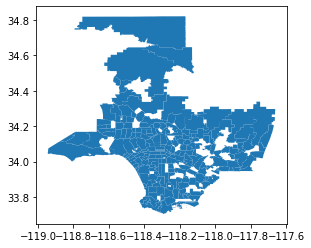

In [36]:
merged_zips_totals.plot()

***

## 2) When were the donations given during the time period?

In [37]:
thiscycletime = thiscycle.groupby(['monthyear','year','month', 'candidate'], as_index=False).agg({'amount_rcvd': ['size', 'mean', 'sum']}, as_index=False)

In [38]:
wide_zips.dtypes

candidate
contributor_zip_code    object
chan_jeong               int64
herb_wesson              int64
holly_mitchell           int64
jan_perry                int64
winner                  object
dtype: object

In [39]:
thiscycletime
flat_columns = [''.join(t) for t in thiscycletime.columns]
thiscycletime.columns = flat_columns
thiscycletime['amount_rcvdmean'] = thiscycletime['amount_rcvdmean'].astype(int)
thiscycletime['amount_rcvdmean'] = thiscycletime['amount_rcvdmean'].round()
thiscycletime.head(10)
thiscycletime['months'] = thiscycletime['monthyear'].dt.strftime('%m/%d/%Y').astype(str)
thiscycletime

monthyear  year month       candidate  amount_rcvdsize  amount_rcvdmean  \
0  2018-12-01  2018    12     Herb Wesson              357             1275   
1  2019-01-01  2019     1     Herb Wesson               78             1048   
2  2019-01-01  2019     1       Jan Perry               59              642   
3  2019-02-01  2019     2     Herb Wesson               36             1031   
4  2019-02-01  2019     2  Holly Mitchell              477              837   
5  2019-02-01  2019     2       Jan Perry               94              839   
6  2019-03-01  2019     3     Herb Wesson              143             1192   
7  2019-03-01  2019     3  Holly Mitchell               19              546   
8  2019-03-01  2019     3       Jan Perry              112              670   
9  2019-04-01  2019     4     Herb Wesson               99             1096   
10 2019-04-01  2019     4  Holly Mitchell               83              527   
11 2019-04-01  2019     4       Jan Perry              126              534   
12 2019-05-01  2019     5      Chan Jeong               77              585   
13 2019-05-01  2019     5     Herb Wesson               95             1056   
14 2019-05-01  2019     5  Holly Mitchell               45              575   
15 2019-05-01  2019     5       Jan Perry               93              556   
16 2019-06-01  2019     6      Chan Jeong                5              200   
17 2019-06-01  2019     6     Herb Wesson              152             1090   
18 2019-06-01  2019     6  Holly Mitchell              143              593   
19 2019-06-01  2019     6       Jan Perry              409              485   

    amount_rcvdsum      months  
0           455299  12/01/2018  
1            81800  01/01/2019  
2            37930  01/01/2019  
3            37150  02/01/2019  
4           399665  02/01/2019  
5            78875  02/01/2019  
6           170550  03/01/2019  
7            10375  03/01/2019  
8            75150  03/01/2019  
9           108596  04/01/2019  
10           43800  04/01/2019  
11           67325  04/01/2019  
12           45100  05/01/2019  
13          100325  05/01/2019  
14           25895  05/01/2019  
15           51725  05/01/2019  
16            1000  06/01/2019  
17          165725  06/01/2019  
18           84859  06/01/2019  
19          198755  06/01/2019

## Let's make some charts
### Totals donations collected by 2020 supervisor candidates since last summer

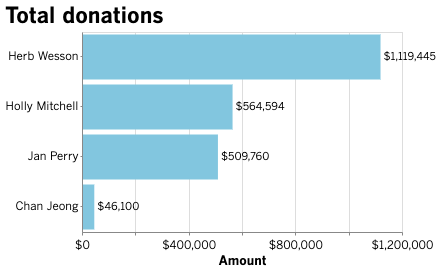

In [40]:

bars = alt.Chart(thiscycletotals, title="Total donations").mark_bar().encode(
    x=alt.X('amount_rcvdsum:Q',title="Amount",axis=alt.Axis(format='$,S', tickCount=4)),
    y=alt.Y(
        'candidate:N',
        title="",
        sort=alt.EncodingSortField(
            field="amount_rcvdsum",  
            op="sum",  
            order="descending",  
    )
)
)

text = bars.mark_text(
    align='left',
    font='Benton Gothic, sans',
    baseline='middle',
    dx=3  
).encode(
    text=alt.Text('amount_rcvdsum:Q', format="$,")
)
    
(bars + text).properties(height=200, width=320)

In [41]:
thiscycletotals

candidate  amount_rcvdsize  amount_rcvdmean  amount_rcvdsum
0      Chan Jeong               82              562           46100
1     Herb Wesson              960             1166         1119445
2  Holly Mitchell              767              736          564594
3       Jan Perry              893              570          509760

### What's the average donation size? 

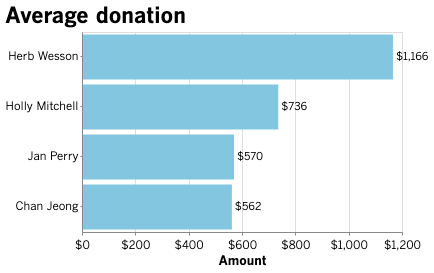

In [42]:
bars = alt.Chart(thiscycletotals, title="Average donation").mark_bar().encode(
    x=alt.X('amount_rcvdmean:Q',title="Amount",axis=alt.Axis(format='$,S', tickCount=4)),
    y=alt.Y(
        'candidate:N',
        title="",
        sort=alt.EncodingSortField(
            field="amount_rcvdmean",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="descending",  # The order to sort in
    )
)
)

text = bars.mark_text(
    align='left',
    font='Benton Gothic, sans',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text=alt.Text('amount_rcvdmean:Q', format="$,")
)

(bars + text).properties(height=200, width=320)

### How many donations have the candidates received? 

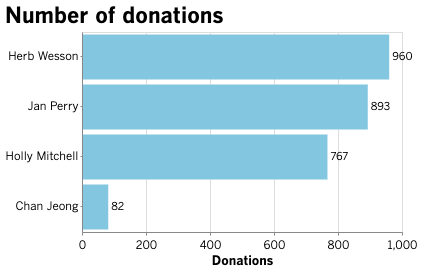

In [43]:
bars = alt.Chart(thiscycletotals, title="Number of donations").mark_bar().encode(
    x=alt.X('amount_rcvdsize:Q',title="Donations",axis=alt.Axis(format=',S', tickCount=6)),
    y=alt.Y(
        'candidate:N',
        title="",
        sort=alt.EncodingSortField(
            field="amount_rcvdsize",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="descending",  # The order to sort in
        )
    )
)

text = bars.mark_text(
    align='left',
    font='Benton Gothic, sans',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text=alt.Text('amount_rcvdsize:Q', format=",")
)
    
(bars + text).properties(height=200, width=320)

### Sum of donations by month

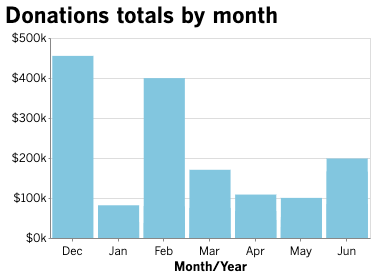

In [44]:
bars = alt.Chart(thiscycletime, title="Donations totals by month").mark_bar().encode(
    x=alt.X("months:O", 
            timeUnit="yearmonth",
            title="Month/Year",
            axis=alt.Axis(format="%b")
           ),
    y=alt.Y(
        'amount_rcvdsum:Q',
        title="",
        axis=alt.Axis(format="$,s")
        )
    )

(bars).properties(height=200, width=320) 

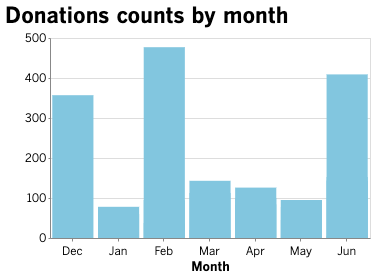

In [45]:
bars = alt.Chart(thiscycletime, title="Donations counts by month").mark_bar().encode(
    x=alt.X("months:O", 
            timeUnit="yearmonth",
            title="Month",
            axis=alt.Axis(format="%b")
           ),
    y=alt.Y(
        'amount_rcvdsize:Q',
        title="",
        sort=alt.EncodingSortField(
            field="amount_rcvdsize",
            op="sum", 
            order="descending",  
        )
    )
)

(bars).properties(height=200, width=320)

### Donations by week

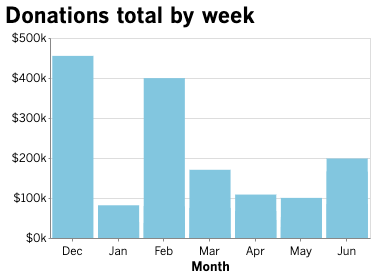

In [46]:
bars = alt.Chart(thiscycletime, title="Donations total by week").mark_bar().encode(
    x=alt.X("months:O", 
            timeUnit="yearmonth",
            title="Month",
            axis=alt.Axis(format="%b")
           ),
    y=alt.Y(
        'amount_rcvdsum:Q',
        title="",
        axis=alt.Axis(format="$,s"),
        sort=alt.EncodingSortField(
            field="amount_rcvdsum",
            op="sum", 
            order="descending",
        )
    )
)

(bars).properties(height=200, width=320)

In [47]:
thiscycletime

monthyear  year month       candidate  amount_rcvdsize  amount_rcvdmean  \
0  2018-12-01  2018    12     Herb Wesson              357             1275   
1  2019-01-01  2019     1     Herb Wesson               78             1048   
2  2019-01-01  2019     1       Jan Perry               59              642   
3  2019-02-01  2019     2     Herb Wesson               36             1031   
4  2019-02-01  2019     2  Holly Mitchell              477              837   
5  2019-02-01  2019     2       Jan Perry               94              839   
6  2019-03-01  2019     3     Herb Wesson              143             1192   
7  2019-03-01  2019     3  Holly Mitchell               19              546   
8  2019-03-01  2019     3       Jan Perry              112              670   
9  2019-04-01  2019     4     Herb Wesson               99             1096   
10 2019-04-01  2019     4  Holly Mitchell               83              527   
11 2019-04-01  2019     4       Jan Perry              126              534   
12 2019-05-01  2019     5      Chan Jeong               77              585   
13 2019-05-01  2019     5     Herb Wesson               95             1056   
14 2019-05-01  2019     5  Holly Mitchell               45              575   
15 2019-05-01  2019     5       Jan Perry               93              556   
16 2019-06-01  2019     6      Chan Jeong                5              200   
17 2019-06-01  2019     6     Herb Wesson              152             1090   
18 2019-06-01  2019     6  Holly Mitchell              143              593   
19 2019-06-01  2019     6       Jan Perry              409              485   

    amount_rcvdsum      months  
0           455299  12/01/2018  
1            81800  01/01/2019  
2            37930  01/01/2019  
3            37150  02/01/2019  
4           399665  02/01/2019  
5            78875  02/01/2019  
6           170550  03/01/2019  
7            10375  03/01/2019  
8            75150  03/01/2019  
9           108596  04/01/2019  
10           43800  04/01/2019  
11           67325  04/01/2019  
12           45100  05/01/2019  
13          100325  05/01/2019  
14           25895  05/01/2019  
15           51725  05/01/2019  
16            1000  06/01/2019  
17          165725  06/01/2019  
18           84859  06/01/2019  
19          198755  06/01/2019

***

# Which types of donors gave to the candidates? 

In [48]:
thiscycle.groupby(['type','candidate'], as_index=False).agg({'amount_rcvd': ['size', 'mean', 'sum']}, as_index=False)

type       candidate amount_rcvd                     
                                                 size         mean     sum
0               Committee     Herb Wesson          39  1365.384615   53250
1               Committee  Holly Mitchell         138  1127.840580  155642
2               Committee       Jan Perry           3   750.000000    2250
3              Individual      Chan Jeong          64   537.500000   34400
4              Individual     Herb Wesson         617  1136.377634  701145
5              Individual  Holly Mitchell         447   465.102908  207901
6              Individual       Jan Perry         794   545.415617  433060
7                   Other      Chan Jeong          18   650.000000   11700
8                   Other     Herb Wesson         289  1194.636678  345250
9                   Other  Holly Mitchell         163  1067.797546  174051
10                  Other       Jan Perry          96   775.520833   74450
11  Small Donor Committee     Herb Wesson          15  1320.000000   19800
12  Small Donor Committee  Holly Mitchell          19  1421.052632   27000

## Share of the candidates' donations by type

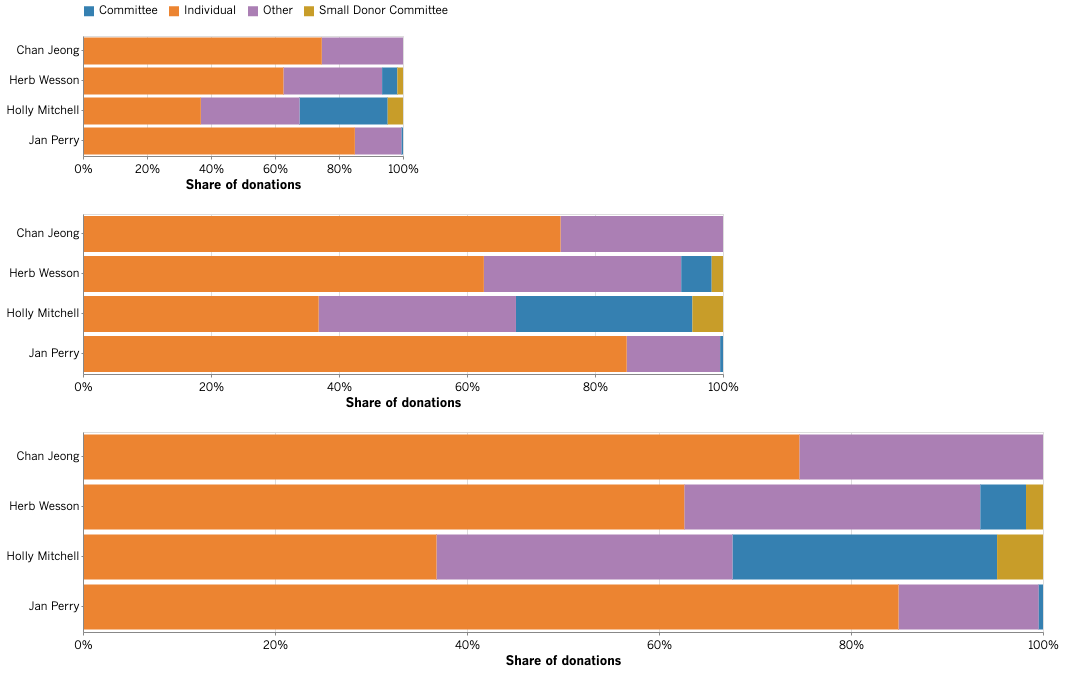

In [49]:
bars320 = alt.Chart(thiscycle, title='').mark_bar().encode(
    x=alt.X('sum(amount_rcvd)', stack="normalize", title="Share of donations",axis=alt.Axis(format='%', tickCount=6)),
    y=alt.Y('candidate', title=""),
    color=alt.Color('type',legend=alt.Legend(title="", orient='top')),
    order=alt.Order('sum(amount_rcvd)', sort='descending')
).properties(height=120, width=320)

bars640 = alt.Chart(thiscycle, title='').mark_bar().encode(
    x=alt.X('sum(amount_rcvd)', stack="normalize", title="Share of donations",axis=alt.Axis(format='%', tickCount=6)),
    y=alt.Y('candidate', title=""),
    color=alt.Color('type',legend=alt.Legend(title="", orient='top')),
    order=alt.Order('sum(amount_rcvd)', sort='descending')
).properties(height=160, width=640)

bars960 = alt.Chart(thiscycle, title='').mark_bar().encode(
    x=alt.X('sum(amount_rcvd)', stack="normalize", title="Share of donations",axis=alt.Axis(format='%', tickCount=6)),
    y=alt.Y('candidate', title=""),
    color=alt.Color('type',legend=alt.Legend(title="", orient='top')),
    order=alt.Order('sum(amount_rcvd)', sort='descending')
).properties(height=200, width=960)



alt.vconcat(bars320, bars640, bars960)


## Which zip codes are in LA County?

### Read in a list extracted from a spatial file

In [50]:
la_zipcodes = pd.read_csv('/Users/mhustiles/Desktop/github/la-supervisors-donations-2020/data/lazips_grouped.csv')

In [51]:
la_zips_list = la_zipcodes['zip_code'].to_csv(header=False, index=False).strip('\n').split('\n')

In [52]:
thiscycletrim.loc[thiscycletrim['contributor_zip_code'].isin(la_zips_list)]
thiscycle_la_zips = thiscycletrim.loc[thiscycletrim['contributor_zip_code'].isin(la_zips_list)]

In [53]:
thiscycletrim['lacounty'] = np.where(thiscycletrim['contributor_zip_code'].isin(la_zips_list), 'Inside LA County', 'Outside LA County')

/Users/mhustiles/.virtualenvs/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Now, what share of each candidates' donations are from LA County?

### Share of donations from inside and outside the county

In [54]:
thiscycletrim.groupby(['lacounty','candidate'], as_index=False).agg({'amount_rcvd': ['sum']}, as_index=False).reset_index()

index           lacounty       candidate amount_rcvd
                                                   sum
0     0   Inside LA County      Chan Jeong       41900
1     1   Inside LA County     Herb Wesson      883399
2     2   Inside LA County  Holly Mitchell      222824
3     3   Inside LA County       Jan Perry      467410
4     4  Outside LA County      Chan Jeong        4200
5     5  Outside LA County     Herb Wesson      236046
6     6  Outside LA County  Holly Mitchell      341770
7     7  Outside LA County       Jan Perry       42350

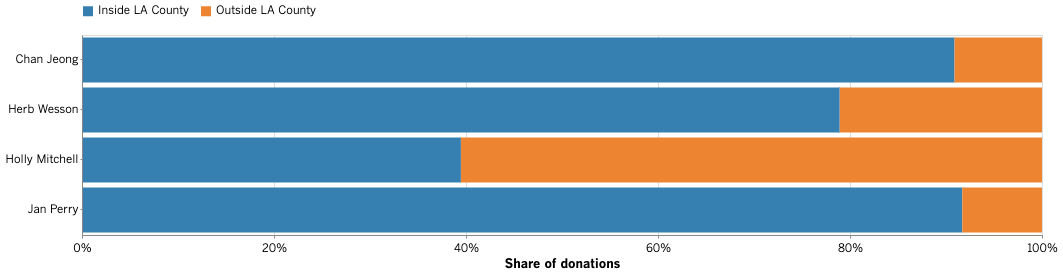

In [55]:
bars = alt.Chart(thiscycletrim, title='').mark_bar().encode(
    x=alt.X('sum(amount_rcvd)', stack="normalize", title="Share of donations", axis=alt.Axis(format='%', tickCount=6)),
    y=alt.Y('candidate', title=""),
    color=alt.Color('lacounty',legend=alt.Legend(title="",orient='top')),
    order=alt.Order('lacounty', sort='ascending')
).properties(height=200, width=960)


bars


In [56]:
thiscycletrim

last_name first_name       candidate committee_id  \
4        WESSON       HERB     Herb Wesson      1414475   
71       WESSON       HERB     Herb Wesson      1414475   
72       WESSON       HERB     Herb Wesson      1414475   
113      WESSON       HERB     Herb Wesson      1414475   
114      WESSON       HERB     Herb Wesson      1414475   
115      WESSON       HERB     Herb Wesson      1414475   
116      WESSON       HERB     Herb Wesson      1414475   
117      WESSON       HERB     Herb Wesson      1414475   
118      WESSON       HERB     Herb Wesson      1414475   
119      WESSON       HERB     Herb Wesson      1414475   
120      WESSON       HERB     Herb Wesson      1414475   
121      WESSON       HERB     Herb Wesson      1414475   
122      WESSON       HERB     Herb Wesson      1414475   
123      WESSON       HERB     Herb Wesson      1414475   
124      WESSON       HERB     Herb Wesson      1414475   
125      WESSON       HERB     Herb Wesson      1414475   
126      WESSON       HERB     Herb Wesson      1414475   
127      WESSON       HERB     Herb Wesson      1414475   
128      WESSON       HERB     Herb Wesson      1414475   
150      WESSON       HERB     Herb Wesson      1414475   
151      WESSON       HERB     Herb Wesson      1414475   
185      WESSON       HERB     Herb Wesson      1414475   
186      WESSON       HERB     Herb Wesson      1414475   
187      WESSON       HERB     Herb Wesson      1414475   
188      WESSON       HERB     Herb Wesson      1414475   
189      WESSON       HERB     Herb Wesson      1414475   
190      WESSON       HERB     Herb Wesson      1414475   
191      WESSON       HERB     Herb Wesson      1414475   
192      WESSON       HERB     Herb Wesson      1414475   
193      WESSON       HERB     Herb Wesson      1414475   
...         ...        ...             ...          ...   
76276    WESSON       HERB     Herb Wesson      1414475   
76277    WESSON       HERB     Herb Wesson      1414475   
76278    WESSON       HERB     Herb Wesson      1414475   
76279    WESSON       HERB     Herb Wesson      1414475   
76280    WESSON       HERB     Herb Wesson      1414475   
76281    WESSON       HERB     Herb Wesson      1414475   
76282    WESSON       HERB     Herb Wesson      1414475   
76283    WESSON       HERB     Herb Wesson      1414475   
76284    WESSON       HERB     Herb Wesson      1414475   
76285    WESSON       HERB     Herb Wesson      1414475   
76286    WESSON       HERB     Herb Wesson      1414475   
76287    WESSON       HERB     Herb Wesson      1414475   
76288    WESSON       HERB     Herb Wesson      1414475   
76289    WESSON       HERB     Herb Wesson      1414475   
76290    WESSON       HERB     Herb Wesson      1414475   
76291    WESSON       HERB     Herb Wesson      1414475   
76292    WESSON       HERB     Herb Wesson      1414475   
76293    WESSON       HERB     Herb Wesson      1414475   
76294    WESSON       HERB     Herb Wesson      1414475   
76295    WESSON       HERB     Herb Wesson      1414475   
76296    WESSON       HERB     Herb Wesson      1414475   
76297    WESSON       HERB     Herb Wesson      1414475   
76298    WESSON       HERB     Herb Wesson      1414475   
76299    WESSON       HERB     Herb Wesson      1414475   
76300    WESSON       HERB     Herb Wesson      1414475   
76301    WESSON       HERB     Herb Wesson      1414475   
76302    WESSON       HERB     Herb Wesson      1414475   
76303    WESSON       HERB     Herb Wesson      1414475   
76304    WESSON       HERB     Herb Wesson      1414475   
77431  MITCHELL   HOLLY J.  Holly Mitchell      1415889   

                                     committee_name office_type  \
4                        WESSON FOR SUPERVISOR 2020         CSU   
71                       WESSON FOR SUPERVISOR 2020         CSU   
72                       WESSON FOR SUPERVISOR 2020         CSU   
113                      WESSON FOR SUPERVISOR 2020         CSU   
114         

### Total amount of donations — by location

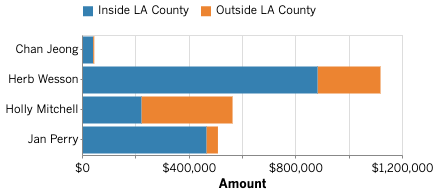

In [57]:
bars = alt.Chart(thiscycletrim, title='').mark_bar().encode(
    x=alt.X('sum(amount_rcvd)', title="Amount", axis=alt.Axis(format='$,S', tickCount=6)),
    y=alt.Y('candidate', title=""),
    color=alt.Color('lacounty',legend=alt.Legend(title="",orient='top')),
    order=alt.Order('lacounty', sort='ascending')
)


(bars).properties(height=200, width=960)
(bars).properties(height=180, width=640)
(bars).properties(height=120, width=320)

### Total amount of donations — by donor type

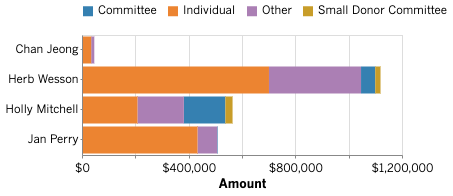

In [58]:
bars = alt.Chart(thiscycletrim, title='').mark_bar().encode(
    x=alt.X('sum(amount_rcvd)', title="Amount",axis=alt.Axis(format='$,S', tickCount=4)),
    y=alt.Y('candidate', title=""),
    color=alt.Color('type',legend=alt.Legend(title="", orient='top')),
    order=alt.Order('sum(amount_rcvd)', sort='descending')
)

(bars).properties(height=200, width=960)
(bars).properties(height=180, width=640)
(bars).properties(height=120, width=320)

***

## Which zip codes are most common?

### Filter for zip codes inside and outside the county

In [59]:
in_la = thiscycletrim[thiscycletrim.lacounty.isin(['Inside LA County'])]
out_la = thiscycletrim[thiscycletrim.lacounty.isin(['Outside LA County'])]

### Donation TOTALS for zips inside and outside the county, by zip

In [60]:
#zip sum totals w/o candidates — in LA
sum_inla_zips = in_la.groupby(['contributor_zip_code'])['amount_rcvd'].agg('sum').reset_index().sort_values(['amount_rcvd','contributor_zip_code',],ascending=False).set_index(['contributor_zip_code'])

#zip sum totals w/o candidates — outside LA
sum_outla_zips = out_la.groupby(["contributor_zip_code"])['amount_rcvd'].agg( 'sum').reset_index().sort_values(['amount_rcvd','contributor_zip_code',],ascending=False).set_index(['contributor_zip_code'])

#zip sum totals w/ candidates — in LA
cand_sum_inla_zips = in_la.groupby(['contributor_zip_code', 'candidate'])['amount_rcvd'].agg('sum').reset_index().sort_values(['amount_rcvd','contributor_zip_code',],ascending=False).set_index(['contributor_zip_code'])

#zip sum totals w/ candidates — out LA
cand_sum_outla_zips = out_la.groupby(["contributor_zip_code",'candidate'])['amount_rcvd'].agg( 'sum').reset_index().sort_values(['amount_rcvd','contributor_zip_code',],ascending=False).set_index(['contributor_zip_code'])

### Donation COUNTS for zips inside and outside the county, by zip

In [61]:
#zip counts w/o candidates — in LA
size_inla_zips = in_la.groupby(['contributor_zip_code']).agg('size').to_frame('size').reset_index().sort_values(['size'], ascending=[False])

#zip counts w/o candidates — out LA
size_outla_zips = out_la.groupby(['contributor_zip_code']).size().to_frame('size').reset_index().sort_values(['size'], ascending=[False])

#zip counts w/ candidates — in LA
cand_size_inla_zips = in_la.groupby(['contributor_zip_code', 'candidate']).size().to_frame('size').reset_index().sort_values(['size'], ascending=[False])

#zip counts w/ candidates — out LA
cand_size_outla_zips = out_la.groupby(['contributor_zip_code', 'candidate']).size().to_frame('size').reset_index().sort_values(['size'], ascending=[False])

In [62]:
cand_size_inla_zips.head(10)

contributor_zip_code       candidate  size
16                 90008       Jan Perry    31
18                 90010     Herb Wesson    29
128                90056       Jan Perry    27
127                90056  Holly Mitchell    25
35                 90015       Jan Perry    25
171                90210       Jan Perry    25
26                 90012       Jan Perry    24
109                90043  Holly Mitchell    23
125                90049       Jan Perry    20
208                90266     Herb Wesson    19

### Which 10 LA zip codes gave the most? 

In [63]:
sum_inla_zips.head(10)

amount_rcvd
contributor_zip_code             
90010                       54400
90210                       45680
90049                       41499
90017                       41150
90020                       35900
90024                       33500
90015                       31975
90019                       31850
90056                       27775
90025                       27510

### Which 10 outside LA zip codes gave the most? 

In [64]:
sum_outla_zips.head(10)

amount_rcvd
contributor_zip_code             
95814                       91300
95815                       12250
92660                        8450
94105                        7500
95816                        7200
92649                        7000
95811                        6750
20001                        6750
60611                        6000
94901                        5500